In [1]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px
import plotly.graph_objects as go

from datetime import date, timedelta, datetime

import plotly.offline as py

import folium 
from folium import plugins

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 시각화, 한글깨짐 처리
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font',family=font_name)

#### 데이터 불러오기

In [3]:
case = pd.read_csv(r'.\data\Case.csv')
time = pd.read_csv(r'.\data\Time.csv')
timeprovince = pd.read_csv(r'./data/TimeProvince.csv')
patient = pd.read_csv(r'.\data\PatientInfo.csv')
route = pd.read_csv(r'./data/PatientRoute.csv')
region = pd.read_csv(r'.\data\Region.csv')
seoul_Floating = pd.read_csv(r'./data/SeoulFloating.csv')

## 1. 집단감염의 위험성 

### 1.1 시간별 데이터 분석

In [4]:
df_before = time.shift(1).dropna()
df_present = time.iloc[1:]
weeks = ['월','화','수','목','금','토','일']
time['weekday'] = list(map(lambda x : weeks[datetime.strptime(x, '%Y-%m-%d').weekday()], time.date))
time['test_p'] = df_present.test - df_before.test
time['negative_p'] = df_present.negative - df_before.negative
time['confirmed_p'] = df_present.confirmed - df_before.confirmed
time['released_p'] = df_present.released - df_before.released
time['deceased_p'] = df_present.deceased - df_before.deceased
time['deceased_ratio'] = time.deceased / time.confirmed

time = time.dropna().reset_index(drop = True)

dates = time.date.unique().astype('str').tolist()

print(df_before.head(5))
print(df_present.head(5))

         date  time  test  negative  confirmed  released  deceased
1  2020-01-20  16.0   1.0       0.0        1.0       0.0       0.0
2  2020-01-21  16.0   1.0       0.0        1.0       0.0       0.0
3  2020-01-22  16.0   4.0       3.0        1.0       0.0       0.0
4  2020-01-23  16.0  22.0      21.0        1.0       0.0       0.0
5  2020-01-24  16.0  27.0      25.0        2.0       0.0       0.0
         date  time  test  negative  confirmed  released  deceased
1  2020-01-21    16     1         0          1         0         0
2  2020-01-22    16     4         3          1         0         0
3  2020-01-23    16    22        21          1         0         0
4  2020-01-24    16    27        25          2         0         0
5  2020-01-25    16    27        25          2         0         0


In [5]:
def make_xaxis(domain, anchor, title = '') :
    return dict(
        showline=True, showgrid=False, showticklabels=True,
        linecolor='rgb(204, 204, 204)', linewidth=2,
        ticks='outside', tickfont=dict(family='Arial', size=12, color='rgb(82, 82, 82)'),
        domain = domain, anchor = anchor, title = title
    )

def make_yaxis(domain, anchor, title = '') : 
    return dict(zeroline=False, gridcolor = 'rgb(192,192,192)',domain = domain, anchor = anchor, title = title)

def frame_args(d1,d2):
    return {
            "frame": {"duration": d1},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": d2, "easing": "linear"},
        }

In [6]:
fig_dict = dict(data = [], layout = {}, frames = [])

colors = ['rgb(40,49,80)', 'rgb(213,71,61)','rgb(38,128,204)','rgb(252,198,1)', 'rgb(150,123,220)']
labels = ['검사자', '음성판정자', '확진자','완치자','사망자']
colnames = ['test_p', 'negative_p','confirmed_p','released_p','deceased_p']
widths = [2,3,3,2,2]

for i, colname in enumerate(colnames): 
    data_dict = go.Scatter(
        x = time.loc[:, 'date'],
        y = time.loc[:, colname],
        text = time.loc[:, 'weekday'], hoverinfo = 'x+y+text',
        name = labels[i], line = dict(width = widths[i], color = colors[i]), connectgaps=True,
        mode = "lines", xaxis = 'x1', yaxis = 'y1'
    )
    fig_dict['data'].append(data_dict)

for i, colname in enumerate(colnames): 
    if i <= 1 : continue
    data_dict = go.Scatter(
        x = time.loc[:, 'date'],
        y = time.loc[:, colname],
        text = time.loc[:, 'weekday'], hoverinfo = 'x+y+text',
        name = labels[i], line = dict(width = widths[i], color = colors[i]), connectgaps=True,
        mode = "lines", xaxis = 'x2', yaxis = 'y2', showlegend = False
    )
    fig_dict['data'].append(data_dict)

fig_dict['layout'] = dict(
    title = "코로나19 일일 현황 (%s ~ %s)" % (dates[0], dates[-1]), font = dict(size = 14),
    width = 800, height = 700, plot_bgcolor = 'white',
    xaxis1 = make_xaxis([0,1],'y1'),
    yaxis1 = make_yaxis([0.55,1], 'x1'),
    xaxis2 = make_xaxis([0,1],'y2'),
    yaxis2 = make_yaxis([0,0.45],'x2'),
    legend = dict(x = 1.05, y = 0.5, bordercolor = 'black', borderwidth = 1)   
)

fig = go.Figure(fig_dict)


fig.add_annotation(
    x = '2020-02-18', y = 0, ax = 0, ay = -50, 
    xref = 'x1', yref = 'y1', text = '신천지>집단 감염',font = dict(size=13, color="#ffffff"), 
    align = 'center', bgcolor="rgb(220,149,123)", 
)
fig.add_annotation(
    x = '2020-02-18', y = 0, ax = 0, ay = -50, 
    xref = 'x2', yref = 'y2', text = '신천지>집단 감염',font = dict(size=13, color="#ffffff"), 
    align = 'center', bgcolor="rgb(220,149,123)"    
)

fig.add_annotation(
    x = '2020-05-06', y = 0, ax = 0, ay = -200, 
    xref = 'x1', yref = 'y1', text = '이태원클럽>집단 감염',font = dict(size=13, color="#ffffff"), 
    align = 'center', bgcolor="rgb(220,149,123)", 
)
fig.add_annotation(
    x = '2020-05-06', y = 0, ax = 0, ay = -50, 
    xref = 'x2', yref = 'y2', text = '이태원클럽>집단 감염',font = dict(size=13, color="#ffffff"), 
    align = 'center', bgcolor="rgb(220,149,123)"    
)

fig.show()

#### 1.2  집단감염 사례 및 집단감염 확진자 비율 _Case.csv 활용

In [7]:
## Get data
import os
last_update = '2020-06-30'
print(f'[Dataset list]\n# updated on %s'%last_update)
file_paths_raw = []
for dirname, _, filenames in os.walk(r'./data/'):
    for filename in filenames:
        file_paths_raw.append(os.path.join(dirname, filename))
file_names = ['TimeAge.csv', 'TimeProvince.csv', 'Region.csv', 'TimeGender.csv'
              , 'Time.csv', 'Case.csv', 'Weather.csv', 'PatientInfo.csv'
              , 'PatientRoute.csv', 'SeoulFloating.csv', 'SearchTrend.csv', 'Policy.csv']
file_paths = [ j for i in file_names for j in file_paths_raw if i in j ]
file_paths

[Dataset list]
# updated on 2020-06-30


['./data/TimeAge.csv',
 './data/TimeProvince.csv',
 './data/Region.csv',
 './data/TimeGender.csv',
 './data/Time.csv',
 './data/Case.csv',
 './data/Weather.csv',
 './data/PatientInfo.csv',
 './data/PatientRoute.csv',
 './data/SeoulFloating.csv',
 './data/SearchTrend.csv',
 './data/Policy.csv']

In [8]:
def get_data(path, transpose=False):
    """
    FUNCTION
        to get and check data from a file path
    @ PARAMS
        path(string) = file path for data
        transpose(bool) = transpose a wide data to show vertically / default=False
    > RETURN
        df_raw = dataframe
    """
    df_raw = pd.read_csv(path)
    print('[Sample data]')
    if transpose:
        display(df_raw.head(3).append(df_raw.tail(3)).T)
    else:
        display(df_raw.head(3).append(df_raw.tail(3)))
    return df_raw

In [9]:
path_raw = get_data(file_paths[5])
print(f'Number of unique paths: {len(path_raw.infection_case.unique())}\n')
print('[6 paths with the most confirmed cases]')
path = path_raw.sort_values('confirmed', ascending=False)
display(path.head(6))

[Sample data]


,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,133.0,37.538621,126.992652
1,1000002,Seoul,Guro-gu,True,Guro-gu Call Center,99.0,37.508163,126.884387
2,1000003,Seoul,Dongdaemun-gu,True,Dongan Church,20.0,37.592888,127.056766
125,7000002,Jeju-do,-,False,contact with patient,0.0,-,-
126,7000003,Jeju-do,-,False,etc,4.0,-,-
127,7000004,Jeju-do,from other city,True,Itaewon Clubs,1.0,-,-


Number of unique paths: 51

[6 paths with the most confirmed cases]


,case_id,province,city,group,infection_case,confirmed,latitude,longitude
29,1200001,Daegu,Nam-gu,True,Shincheonji Church,4510.0,35.84008,128.5667
37,1200009,Daegu,-,False,contact with patient,920.0,-,-
38,1200010,Daegu,-,False,etc,737.0,-,-
102,6000001,Gyeongsangbuk-do,from other city,True,Shincheonji Church,566.0,-,-
16,1000017,Seoul,-,False,overseas inflow,346.0,-,-
75,2000010,Gyeonggi-do,-,False,overseas inflow,252.0,-,-


In [10]:
#확진자 수가 100명 이상인 데이터
case100 = case[case['confirmed'] >= 100]
#확진자 수가 100명 이상인 감염경로 파악
case100 = pd.DataFrame(case100.groupby(['infection_case'])['confirmed'].max())
case100 = case100.sort_values(by=['confirmed'], ascending=False)
#주요 감염경로 비율 시각화
fig = px.pie(case100, values='confirmed', names= case100.index, title='주요 감염경로')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

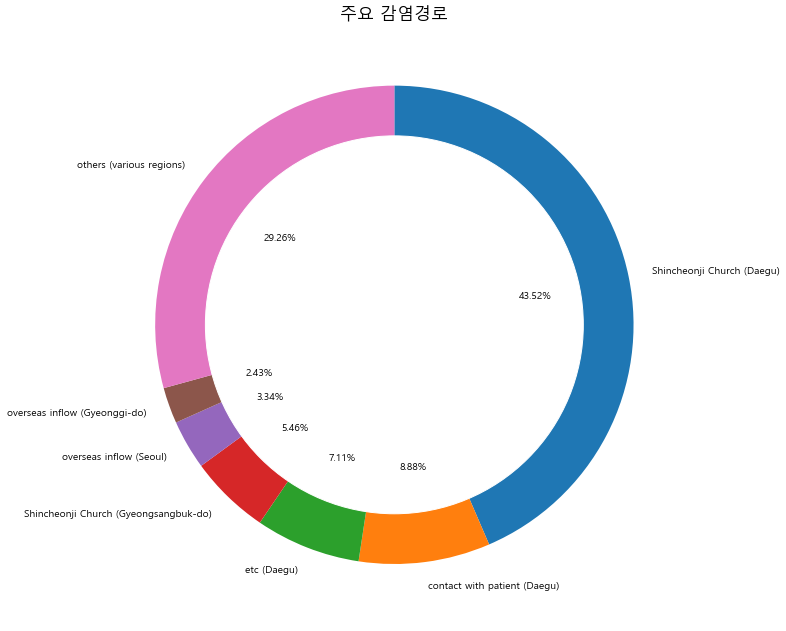

In [11]:
# Put paths other than those with the 6 most confirmed cases into others
path.loc[len(path), :] = path[path.confirmed<path.confirmed.iloc[5]].sum()
path.loc[len(path)-1, 'case_id'] = 0
path.loc[len(path)-1, 'province'] = 'various regions'
path.loc[len(path)-1, 'city'] = 'various cities'
path.loc[len(path)-1, 'group'] = 'various groups'
path.loc[len(path)-1, 'infection_case'] = 'others'
path.loc[len(path)-1, 'latitude'] = '-'
path.loc[len(path)-1, 'longitude'] = '-'
path_with_others = path[path.confirmed >= path.confirmed.iloc[5]]

# Plot distribution
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'주요 감염경로', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(path_with_others.confirmed, autopct='%.2f%%'
        , labels=path_with_others.infection_case + ' (' + path_with_others.province + ')'
#         , explode=(0.03, 0, 0, 0, 0, 0, 0)
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

In [11]:
path_group = path_raw.groupby('group').sum().sort_values('confirmed', ascending=False)
path_group.index = ['집단', '개인']
print('[Type of transmission]')
path_group

[Type of transmission]


,case_id,confirmed
집단,212300354,7174.0
개인,154300329,3190.0


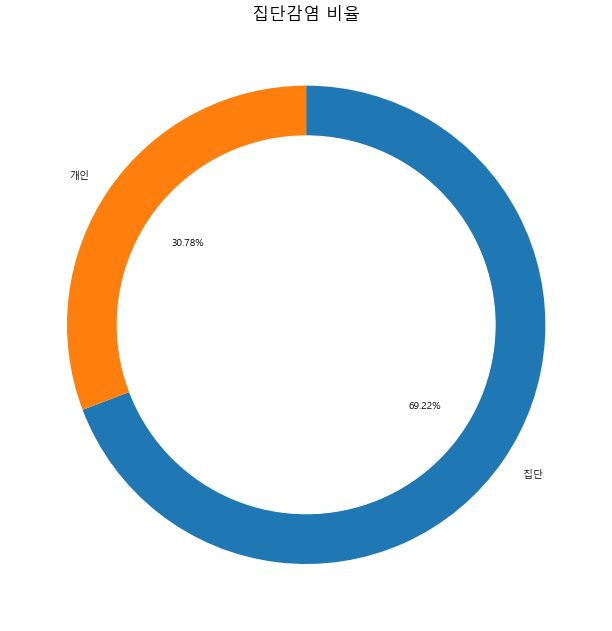

In [12]:
fig, ax = plt.subplots(figsize=(11, 11))
plt.title(f'집단감염 비율', fontsize=17)
pop_circle=plt.Circle((0,0), 0.79, color='white')
plt.pie(path_group.confirmed
        , autopct='%.2f%%'
        , labels=path_group.index
        , startangle=90
        , counterclock=False)
p=plt.gcf()
p.gca().add_artist(pop_circle)
plt.show()

### 1-3. 집단감염에 따른 유동인구와 코로나검색량 변화

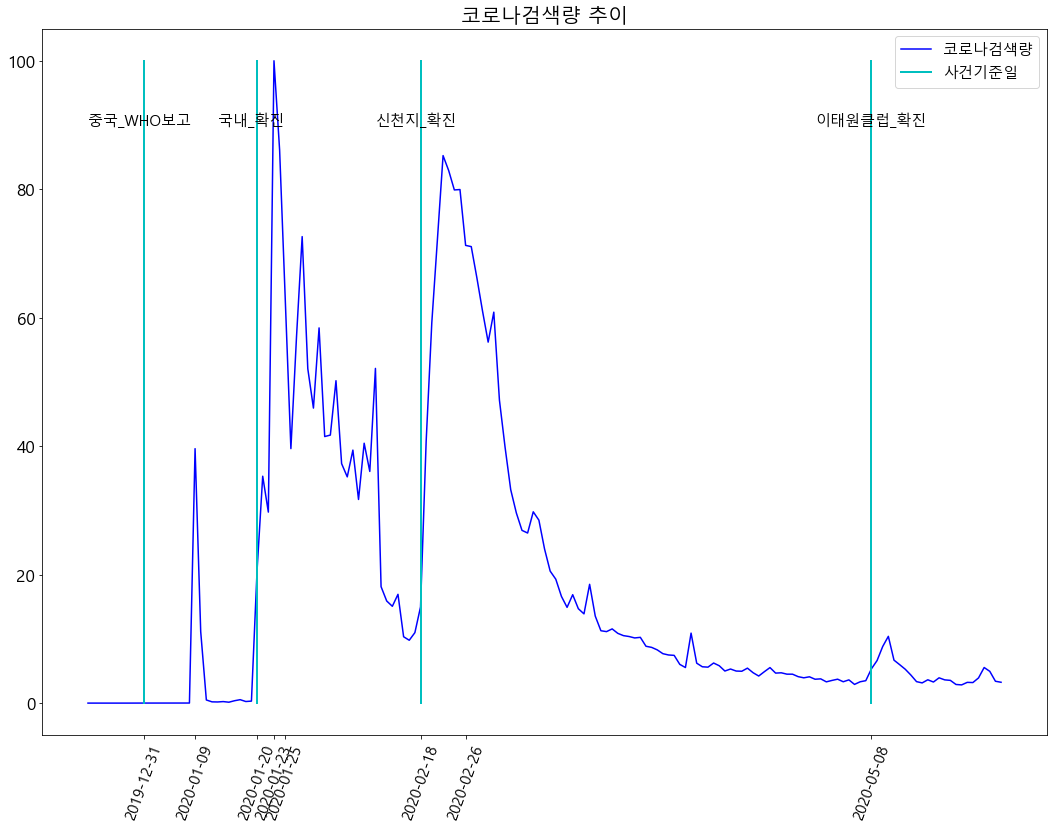

In [13]:
# 코로나 검색 데이터 및 서울 유동인구 데이터 불러오기
ST = pd.read_csv(r'./data/SearchTrend.csv')
SF = pd.read_csv(r'./data/SeoulFloating.csv')
SF = SF[SF['date']!='2020-02-23']


plt.figure(figsize=(18,13))
plt.plot(ST['date'][1450:1614],ST['coronavirus'][1450:1614],lw=1.5,c='blue')
plt.plot([ST['date'][ST[ST['date']=='2020-01-20'].index[0]],ST['date'][ST[ST['date']=='2020-01-20'].index[0]]],[0,100],lw=2, c='c')
plt.plot([ST['date'][ST[ST['date']=='2019-12-31'].index[0]],ST['date'][ST[ST['date']=='2019-12-31'].index[0]]],[0,100],lw=2, c='c')
plt.plot([ST['date'][ST[ST['date']=='2020-02-18'].index[0]],ST['date'][ST[ST['date']=='2020-02-18'].index[0]]],[0,100],lw=2, c='c')
plt.plot([ST['date'][ST[ST['date']=='2020-05-08'].index[0]],ST['date'][ST[ST['date']=='2020-05-08'].index[0]]],[0,100],lw=2, c='c')
plt.annotate('국내_확진',[ST['date'][ST[ST['date']=='2020-01-20'].index[0]-7],90],fontsize=15)
plt.annotate('중국_WHO보고',[ST['date'][ST[ST['date']=='2019-12-31'].index[0]-10],90],fontsize=15)
plt.annotate('신천지_확진',[ST['date'][ST[ST['date']=='2020-02-18'].index[0]-8],90],fontsize=15)
plt.annotate('이태원클럽_확진',[ST['date'][ST[ST['date']=='2020-05-06'].index[0]-8],90],fontsize=15)
plt.xticks(['2019-12-31','2020-01-09','2020-01-20','2020-01-23','2020-01-25','2020-02-18','2020-02-26', '2020-05-08'],rotation=70, fontsize=15)
plt.yticks(fontsize=17)
plt.legend(['코로나검색량','사건기준일'],loc='upper right',fontsize=15)
plt.title('코로나검색량 추이',fontsize=20)
plt.show()

#### >>>>>>>>>>>현재까지 완성된 부분은 여기까지 입니다. 

In [16]:
def data_range(data, column, describe=None):
    """
    FUNCTION
        to check date range of time series or scarce chronological data
    @ PARAMS
        data(dataframe) = data to check
        column(string) = column name for date
        describe(string) = additional description on date column
                           e.g. starting_date
    > RETURN
        None
    """
    data_col = pd.to_datetime(data[column]).dt.date
    date_range = (max(data_col) - min(data_col)).days + 1
    if describe==None:
        print(f'Date range: {date_range} days')
    else:
        print(f'Date range ({describe}): {date_range} days')
    print(f'# {min(data_col)} to {max(data_col)}')
    return None

In [19]:
def plot_lines(data, column_list, column_max, title):
    """
    FUCNTION
        to show many plots with combinations of lines with consistent colors and legend
        useful for plotting lines with different scales at once and then separately
    @ PARAMS
        data = dataframe to plot
        column_list = columns to have numeric values, each can be the initial column to plot up to column_max
        column_max = the last column to plot from the initial column in column_list for len(column_list)
        title(string) = plot title
    > RETURN
        None
    """
    for i in column_list:
        fig, ax = plt.subplots(figsize=(13, 7))
        plt.title(f'{title}', fontsize=17)
        color_group = color_list[:-4][-(column_max-i):]
        for test_each, color_each in zip(data.columns[i:column_max], color_group):
            plt.plot(data.date, data[test_each]
                     , label=test_each, color=color_each
                    )
            label=data[test_each]
        ax.set_xticks(ax.get_xticks()[::int(len(data.date)/8)])
        plt.xlabel('Date', size=13)
        plt.ylabel('Number of cases', size=13)
        ax.legend(loc='upper left')
        plt.show()

In [21]:
color_list = ['#8DD3C7', '#FEFFB3', '#BFBBD9'
              , '#FA8174', '#81B1D2', '#FDB462'
              , '#B3DE69', '#BC82BD', '#CCEBC4']

In [17]:
test_raw = get_data(file_paths[4])
data_range(test_raw, 'date')

[Sample data]


,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
130,2020-05-29,0,885120,849161,11402,10363,269
131,2020-05-30,0,902901,865162,11441,10398,269
132,2020-05-31,0,910822,876060,11468,10405,270


Date range: 133 days
# 2020-01-20 to 2020-05-31


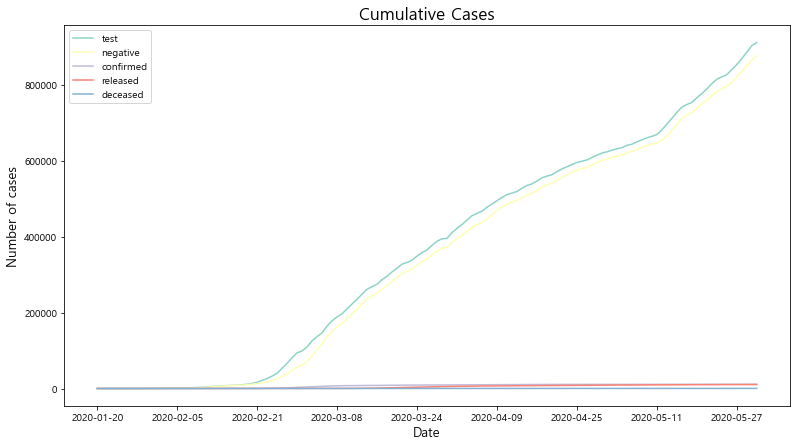

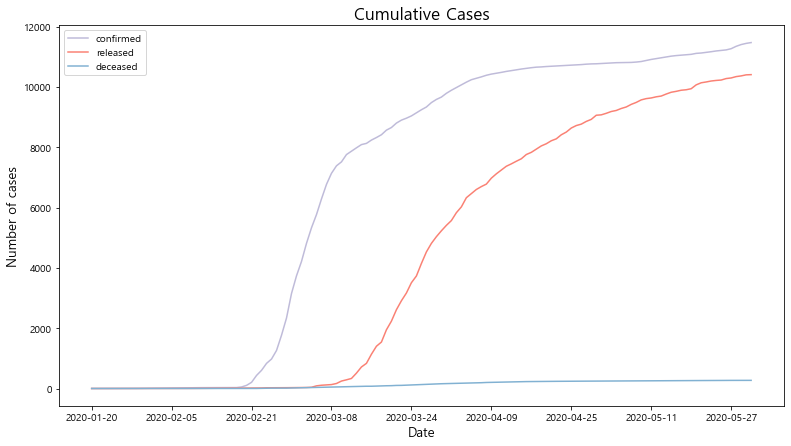

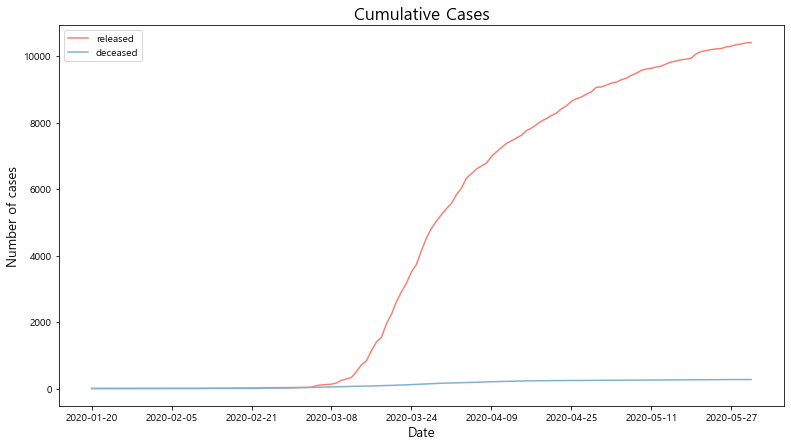

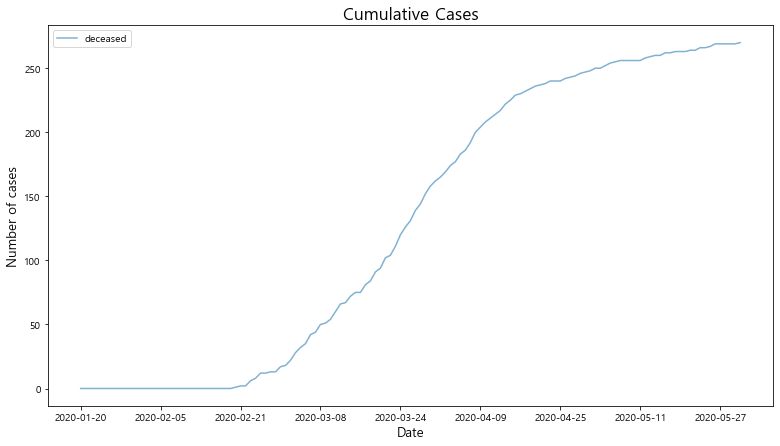

In [22]:
plot_lines(test_raw, [2, 4, 5, 6], 7, 'Cumulative Cases')

#### <서울시 유동인구>

In [45]:

# https://data.seoul.go.kr/dataList/catalogView.do?infId=OA-11677&srvType=S&currentPageNo=1
# 참조
seoul_Floating = pd.read_csv(r'./data/SeoulFloating.csv')
# seoul_Loc = pd.read_csv(r'./data/서울시 행정구역 시군구 정보 (좌표계_ WGS1984).csv', encoding = 'cp949')
# seoul_Floating = pd.merge(seoul_Floating, seoul_Loc, how = 'left').dropna().reset_index()
seoul_Floating['date_time'] = list(map(lambda x, y  : datetime.strptime('%s %02d'%(x, y),'%Y-%m-%d %H'), seoul_Floating.date, seoul_Floating.hour))
weeks = ['월','화','수','목','금','토','일']
seoul_Floating['weekday'] = list(map(lambda x : weeks[datetime.strptime(x, '%Y-%m-%d').weekday()], seoul_Floating.date))
Floating_dates = seoul_Floating.date.unique().tolist()
seoul_Floating['week'] = 0 
seoul_Floating.loc[(seoul_Floating.weekday == '토') | (seoul_Floating.weekday == '일'),'week'] = 'weekend'
seoul_Floating.loc[(seoul_Floating.weekday != '토') & (seoul_Floating.weekday != '일'),'week'] = 'weekday'

seoul_Floating = seoul_Floating[seoul_Floating.date != '2020-02-23'].reset_index(drop = True) # 데이터 이상

seoul_Floating['weekday2'] = seoul_Floating['weekday']
seoul_Floating.loc[seoul_Floating.date == '2020-01-01', 'weekday2'] = '휴일'
seoul_Floating.loc[seoul_Floating.date == '2020-01-24', 'weekday2'] = '휴일'
seoul_Floating.loc[seoul_Floating.date == '2020-01-25', 'weekday2'] = '휴일'
seoul_Floating.loc[seoul_Floating.date == '2020-01-26', 'weekday2'] = '휴일'
seoul_Floating.loc[seoul_Floating.date == '2020-01-27', 'weekday2'] = '휴일'

df_date = seoul_Floating.groupby(['date','weekday','weekday2']).fp_num.mean().reset_index()
df_date_time = seoul_Floating.groupby(['date_time','weekday','weekday2']).fp_num.mean().reset_index()
df_hour = seoul_Floating.groupby(['date','hour','weekday','weekday2']).fp_num.mean().reset_index()
week_dates = df_date.loc[(df_date.weekday != '토') & (df_date.weekday != '일'), 'date']
weekend_dates = df_date.loc[(df_date.weekday == '토') | (df_date.weekday == '일'), 'date']
week_colors = np.where(pd.DataFrame(week_dates) >= '2020-02-18', 'crimson', 'rgb(106,194,194)').tolist()
weekend_colors = np.where(pd.DataFrame(weekend_dates) >= '2020-02-18', 'crimson', 'rgb(106,194,194)').tolist()
week_colors[0] = week_colors[17] = week_colors[18] = ['lightgray']
weekend_colors[6] = weekend_colors[7] = ['lightgray']

In [28]:
fig_dict = dict(data = [], layout = {}, frames = [])

data_dict = go.Scatter(
        x = df_date_time.date_time,
        y = df_date_time.fp_num, text = df_date_time.weekday,
        mode = "lines", line = dict(width = 2,), connectgaps=True, showlegend = False,
        xaxis = 'x1', yaxis = 'y1',  hoverinfo = 'x+y+text',
    )
fig_dict['data'].append(data_dict)

for i, date in enumerate(week_dates) : 
    data_dict = go.Scatter(
        x = df_hour.loc[df_hour.date == date, 'hour'],
        y = df_hour.loc[df_hour.date == date, 'fp_num'], 
        line = dict(width = 2, color = week_colors[i][0]),
        name = date, mode = "lines", connectgaps=True, showlegend = False,
        xaxis = 'x2', yaxis = 'y2', 
    )
    fig_dict['data'].append(data_dict)

colors = np.where(pd.DataFrame(weekend_dates) >= '2020-02-18', 'crimson', 'lightgray')
for i, date in enumerate(weekend_dates) : 
    data_dict = go.Scatter(
        x = df_hour.loc[df_hour.date == date, 'hour'],
        y = df_hour.loc[df_hour.date == date, 'fp_num'], 
        line = dict(width = 2, color = weekend_colors[i][0]),
        name = date, mode = "lines",connectgaps=True, showlegend = False,
        xaxis = 'x3', yaxis = 'y3', 
    )
    fig_dict['data'].append(data_dict)
    
fig_dict['layout'] = dict(
    title = "서울시 유동 인구 (%s ~ %s)" % (Floating_dates[0], Floating_dates[-1]), font = dict(size = 14),
    width = 840, height = 700, plot_bgcolor = 'white',
    
    xaxis1= make_xaxis([0,1], 'y1','날짜 시간별'),
    yaxis1= make_yaxis([0.6,1], 'x1'),
    xaxis2= make_xaxis([0,0.45], 'y2','시간별 (평일)'),
    yaxis2 = dict(gridcolor = 'rgb(192,192,192)',domain = [0,0.4], range = [22000,30000],anchor = 'x2'),
    xaxis3= make_xaxis([0.55,1], 'y3','시간별 (주말)'),
    yaxis3 = dict(gridcolor = 'rgb(192,192,192)',domain = [0,0.4], range = [22000,30000],anchor = 'x3'),

    
    # 
    annotations = [dict(
        x = '2020-05-06', y = 20000, ax = 0, ay = -215, 
        xref = 'x1', yref = 'y1', text = '이태원클럽>집단 감염',font = dict(size=12, color="#ffffff"), 
        align = 'center', bgcolor="orange", arrowcolor = 'orange', arrowwidth = 1
    )
    ,dict(
        x = '2020-02-18', y = 20000, ax = 0, ay = -215, 
        xref = 'x1', yref = 'y1', text = '신천지>집단 감염',font = dict(size=12, color="#ffffff"), 
        align = 'center', bgcolor="orange", arrowcolor = 'orange', arrowwidth = 1
    ), dict(
        x = '2020-01-21', y = 20000, ax = 0, ay = -215, 
        xref = 'x1', yref = 'y1', text = '한국>최초 감염',font = dict(size=12, color="#ffffff"), 
        align = 'center', bgcolor="orange", arrowcolor = 'orange', arrowwidth = 1
    )]
)
    
fig = go.Figure(fig_dict)

fig.show()

NameError: name 'df_date_time' is not defined